# %% [markdown]
# # OPE Evaluation with Preprocessed Dataset
# ---
# This notebook evaluates several contextual bandit policies (Random, Thompson Sampling, and LinUCB with different ε-values) using your **preprocessed dataset**.
# 
# The procedure follows the OBP framework and includes:
# - (1) Loading preprocessed data
# - (2) Policy definition and action distribution
# - (3) Reward modeling
# - (4) Off-Policy Evaluation (OPE) with IPW, DM, DR

Import relevant Libraries:

In [7]:
import numpy as np
import numpy as np
from sklearn.linear_model import LogisticRegression
from obp.policy import BernoulliTS, LinUCB, LinEpsilonGreedy
from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust,
)

### 1 Load Preprocessed Data
We create a dictionary `bandit_feedback` with:
- context
- action
- reward
- pscore
- position (if list-wise, else fill with 0s)

In [8]:
bandit_feedback = dict(
    n_actions=3,
    context=np.load("processed_top3/context_reduced.npy"),
    action=np.load("processed_top3/actions.npy"),
    reward=np.load("processed_top3/rewards.npy"),
    pscore=np.load("processed_top3/pscores.npy"),
)
bandit_feedback["position"] = np.zeros_like(bandit_feedback["action"])  # required dummy
print("Context shape:", bandit_feedback["context"].shape)

Context shape: (53988, 12)


### 2 Define Evaluation Policies

In [9]:
n_rounds = len(bandit_feedback["action"])
n_actions = int(np.max(bandit_feedback["action"]) + 1)
dim_context = bandit_feedback["context"].shape[1]

policies = {
    "Random": None,  # defined manually below
    "TS": BernoulliTS(n_actions=n_actions, len_list=1, random_state=123),
    "LinUCB (\u03b1=0.0)": LinUCB(n_actions=n_actions, dim=dim_context, epsilon=0.0, random_state=1),
    "LinUCB (\u03b1=0.1)": LinUCB(n_actions=n_actions, dim=dim_context, epsilon=0.1, random_state=2),
    "LinUCB (\u03b1=0.5)": LinUCB(n_actions=n_actions, dim=dim_context, epsilon=0.5, random_state=3),
    "LinEG (\u03B5=0.1)": LinEpsilonGreedy(n_actions=n_actions, dim=dim_context, epsilon=0.1, random_state=4),
}

We compute action distributions:

In [10]:
action_dists = {}

for name, policy in policies.items():
    if name == "Random":
        action_dists[name] = np.ones((n_rounds, n_actions, 1)) / n_actions
    elif hasattr(policy, "compute_batch_action_dist"):
        action_dists[name] = policy.compute_batch_action_dist(n_rounds=n_rounds, n_sim=10000)
    else:
        # For LinUCB and LinEpsilonGreedy: simulate batch manually
        action_dist = np.full((n_rounds, n_actions, 1), policy.epsilon / n_actions)
        greedy_actions = np.zeros(n_rounds, dtype=int)
        for i in range(n_rounds):
            x_i = bandit_feedback["context"][i].reshape(1, -1)
            greedy_actions[i] = policy.select_action(context=x_i)
            action_dist[i, greedy_actions[i], 0] += 1.0 - policy.epsilon
        action_dists[name] = action_dist

### 3 Reward Model for DM and DR

In [11]:
regression_model = RegressionModel(
    n_actions=n_actions,
    len_list=1,
    base_model=LogisticRegression(max_iter=1000, random_state=123),
)

estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bandit_feedback["context"],
    action=bandit_feedback["action"],
    reward=bandit_feedback["reward"],
    position=bandit_feedback["position"],
    pscore=bandit_feedback["pscore"],
    n_folds=3,
    random_state=123,
)

### 4. Off-Policy Evaluation

In [12]:
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), DoublyRobust()],
)

estimated_values = {}
estimated_intervals = {}

for name in policies:
    print(f"Evaluating: {name}")
    est_val, ci = ope.summarize_off_policy_estimates(
        action_dist=action_dists[name],
        estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
        n_bootstrap_samples=1000,
        random_state=42,
    )
    estimated_values[name] = est_val
    estimated_intervals[name] = ci

Evaluating: Random
Evaluating: TS
Evaluating: LinUCB (α=0.0)
Evaluating: LinUCB (α=0.1)
Evaluating: LinUCB (α=0.5)
Evaluating: LinEG (ε=0.1)


#### **Relative Policy Values**

Context shape: (53988, 12)
Evaluating: Random
Evaluating: TS
Evaluating: LinUCB (ε=0.0)
Evaluating: LinUCB (ε=0.1)
Evaluating: LinUCB (ε=0.5)
Evaluating: LinEG (ε=0.1)


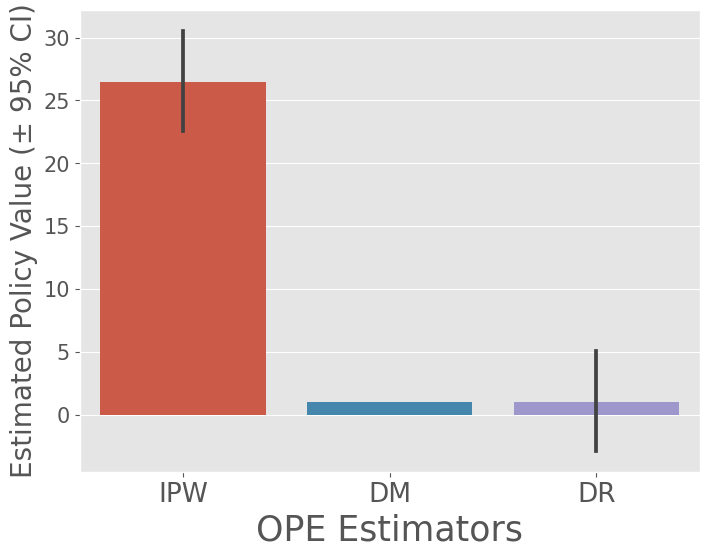

In [ ]:

ope.visualize_off_policy_estimates(
    action_dist=action_dists["TS"],
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    is_relative=True,
    n_bootstrap_samples=1000,
    random_state=42,
)

# You can repeat the above plot for each policy by changing action_dist
